 ## **[코드 내용]**
 
 ### 0. 공통 코드 부분 (필요한 라이브러링 설치 및 자연어처리)
 
 
 ### 1. 토픽 모델링 
    
    
 ### 2. 감정분석
   

# 0. 공통 코드 부분(필요한 라이브러리 설치, 자연어 처리)

## 필요한 라이브러리 설치

In [2]:
# !pip install networkx
# !pip install gensim
# !pip install pyLDAvis
# !pip install xlsxwriter
# !pip install nltk
# !pip install numpy

In [1]:
import re
import json
import pandas as pd
import xlsxwriter
import numpy as np

### option A: 네이버 블로그 csv파일 불러올 때는 이하의 코드를 실행한 후 optionB (쇼핑후기) 코드는 건너뛰고 바로 공통 코드로 이동

In [2]:
blog_df = pd.read_csv('data/skm_blog.csv', encoding='utf-8-sig') # 네이버 블로그 csv파일 불러오기

In [3]:
blog_df = blog_df.sort_values(by='Post Date' ,ascending=True) # post Date를 기준으로 오름차순으로 정렬
blog_df['Post Date'] = [str(dates).replace('.0','') for dates in blog_df['Post Date']] # 분석을 위해서 날짜의 형식을 변경함. 

In [4]:
# 문서에 'Post Date'에서 빈칸을 nan (빈데이터)를 찾아주고 삭제해주는 과정 = 나중에 분석에 오류를 없애기 위해서
drop_index = blog_df['Post Date'][blog_df['Post Date']=='nan'].index
d = [d for d in drop_index] 
print(d, '\n') # 아래 결과 예) 751 번째 행의 날짜가 nan으로 표시 되어있음을 알 수 있음. 

blog_df.drop(d, axis=0, inplace=True) # nan 데이터가 있는 행을 삭제해줌.
print(blog_df.shape)

[362] 

(559, 7)


In [5]:
# 필요한 부분만 편집해서 가져오기. 
# 블로그 데이터 파일에서 블로그 제목인 'Title'과 블로그 내용인 'Description' 및 게시일인 'Post Date'에 해당하는 부분만 가져와 저장.
tm_post = blog_df.get('Title') + " " + blog_df.get('Description')
tm_post_date = blog_df.get('Post Date')

tm_post

292    [차트뉴스] SK매직, 식기세척기 시장 만년 1위 오죽하면 빨래건조기, 로봇 청소기...
521    동양매직에서 SK매직으로 이름이 바뀐 슈퍼 공기청정기...  동양매직에서 SK매직으...
96     SK매직 무선청소기 VCL-D200 개봉기 및 사용기 SK매직 무선청소기 VCL-D...
534    내돈주고 사서쓰는 유선진공청소기 SK매직 VCL-613 아기가 생긴 뒤로 내 머리카...
274    소형가전(무선청소기... ZB3233B /SK매직 EON-30AMD 다른 청소기를 ...
                             ...                        
103    삼성비스포크 렌탈 케어 SK매직 스페셜 렌탈 서비스 받은 후기! SK매직 렌탈서비스...
164    SK 매직 공기청정기 제로웨이스트 친환경가전 제대로네 공기청정기네요 SK매직 그린컬...
25     예쁜가전 SK매직 올클린 공기청정기로 집안공기까지 예쁘게~ 바로 예쁜가전 SK매직 ...
21     우리집 미세먼지는 SK매직 올클린 공기청정기 Green 242 환경까지 고려한 친환...
19     SK매직 공기청정기 Green 242 필수가전 인것 같아요 인 SK매직 올클린 공기...
Length: 559, dtype: object

### option B: 네이버 쇼핑후기 csv파일 불러올 때는 위의 optionA (네이버 블로그) 코드를 건너뛰고 이 코드를 실행한 후 이어서 공통코드 실행¶

In [7]:
shop_df = pd.read_csv('data/skm_shopping.csv', encoding='utf-8-sig') # 네이버 쇼핑몰 데이터 불러오기
shop_df.head()

,type,category,date,title,review,star
0,sk매직 청소기,별점,20190723,놀랍네요,원목마루라 스팀청소 후 뒤틀림이 발생해서 매일 마른걸레질과 간혹 물걸레를 사용했었는...,평점5
1,sk매직 청소기,별점,20201119,무선 물걸레 사용은 처음이고 다른 제품 사용을 안해 봐서 비교 하기는 어렵지만 조립...,무선 물걸레 사용은 처음이고 다른 제품 사용을 안해 봐서 비교 하기는 어렵지만 조립...,평점5
2,sk매직 청소기,별점,20210717,배송은 소소. 포장은 박스를 누군가 개봉한 흔적이 살짝 보이는데 신경 안 씁니다.다...,배송은 소소. 포장은 박스를 누군가 개봉한 흔적이 살짝 보이는데 신경 안 씁니다.\...,평점5
3,sk매직 청소기,별점,20201114,즌작살껄~~,타사제품 2대써봤어요한대는 성능이 좋았지만 유선이라 30평대 넘어가면 줄 이리저리 ...,평점5
4,sk매직 청소기,별점,20190724,SK매직스핀업 무선물걸레청소기 VCL-W10B 패드2장추가,헤드부분이 무게감이 있어 힘들이지 않고 걸레질이 아주양호하게 잘됨 32평형 청소 힘...,평점5


In [8]:
# 필요한 부분만 편집해서 가져오기. 
# 블로그 데이터 파일에서 블로그 제목인 'title'과 블로그 내용인 'review' 및 게시일인 'date'에 해당하는 부분만 가져와 저장.
tm_post = shop_df.get('title') + " " + shop_df.get('review')
tm_post_date = shop_df.get('date')

tm_post

0      놀랍네요 원목마루라 스팀청소 후 뒤틀림이 발생해서 매일 마른걸레질과 간혹 물걸레를 ...
1      무선 물걸레 사용은 처음이고 다른 제품 사용을 안해 봐서 비교 하기는 어렵지만 조립...
2      배송은 소소. 포장은 박스를 누군가 개봉한 흔적이 살짝 보이는데 신경 안 씁니다.다...
3      즌작살껄~~ 타사제품 2대써봤어요한대는 성능이 좋았지만 유선이라 30평대 넘어가면 ...
4      SK매직스핀업 무선물걸레청소기 VCL-W10B 패드2장추가 헤드부분이 무게감이 있어...
                             ...                        
995    아이들이 있어서 청소를 잘 못했는데 소음이 작아서 아이들 잘 때 하면 되서 좋네요 ...
996    간단한 조작법으로 쉽게쉽게 청소가 끝나네요 ㅎㅎ 간단한 조작법으로 쉽게쉽게 청소가 ...
997    구석구석 잘 닦여요 ㅎㅎ 손목에도 무리가 없습니당 구석구석 잘 닦여요 ㅎㅎ 손목에도...
998    조명이 달려있어서 밤에 조용히 물걸레질을 할 수 있어서 좋네요^^ 조명이 달려있어서...
999              정말 물자국이 남지않아요 ㅇ0ㅇ!! 정말 물자국이 남지않아요 ㅇ0ㅇ!!
Length: 1000, dtype: object

### 공통: 여기에서부터는 optionA (블로그) 및 optionB(쇼핑후기) 공통으로 진행하는 코드

In [6]:
tm_post.head()  # 첫 5행 보여주기

292    [차트뉴스] SK매직, 식기세척기 시장 만년 1위 오죽하면 빨래건조기, 로봇 청소기...
521    동양매직에서 SK매직으로 이름이 바뀐 슈퍼 공기청정기...  동양매직에서 SK매직으...
96     SK매직 무선청소기 VCL-D200 개봉기 및 사용기 SK매직 무선청소기 VCL-D...
534    내돈주고 사서쓰는 유선진공청소기 SK매직 VCL-613 아기가 생긴 뒤로 내 머리카...
274    소형가전(무선청소기... ZB3233B /SK매직 EON-30AMD 다른 청소기를 ...
dtype: object

In [7]:
tm_post.tail()  # 마지막 5행 보여주기

103    삼성비스포크 렌탈 케어 SK매직 스페셜 렌탈 서비스 받은 후기! SK매직 렌탈서비스...
164    SK 매직 공기청정기 제로웨이스트 친환경가전 제대로네 공기청정기네요 SK매직 그린컬...
25     예쁜가전 SK매직 올클린 공기청정기로 집안공기까지 예쁘게~ 바로 예쁜가전 SK매직 ...
21     우리집 미세먼지는 SK매직 올클린 공기청정기 Green 242 환경까지 고려한 친환...
19     SK매직 공기청정기 Green 242 필수가전 인것 같아요 인 SK매직 올클린 공기...
dtype: object

In [8]:
tm_post_date.max()   # 최대 날짜 (가장 최근 데이터)

'20211101'

In [9]:
tm_post_date.min()  # 최소 날짜 (가장 오래된 데이터)

'20161202'

In [10]:
# tm_post 전처리

print(tm_post.isnull().values.any()) # 빈 행이 있는지 확인하기 ( 뒤에 에러가 날 수 있음 ) 
print(tm_post.isnull().sum()) # null 값이 총 몇개가 있는지 확인 

tm_post = tm_post.dropna(how = 'any') # Null 값이 존재하는 행을 제거

False
0


In [11]:
len(tm_post)

559

In [12]:
import re

def cleanText(datas): # 단어 전처리
    data1 = re.sub('[^A-Za-z0-9가-힣;,.?!]', ' ', datas)
    data1 = data1.replace(' 청소기', ' 청소기 ') #검색어 띄어쓰기 붙여주기
    data1 = data1.replace('청소기 ', ' 청소기 ') #검색어 띄어쓰기 붙여주기
    data1 = data1.replace('  ', ' ')
    #data1 = data1.replace('청소', '청소기')
    data2 = data1.split()
    return data1

In [13]:
tm_posts = []
for posts in tm_post:
    post = cleanText(posts)
    post1 = ' '.join(post)
    tm_posts.append(post)
    
tm_posts[:3]

[' 차트뉴스 SK매직, 식기세척기 시장 만년 1위 오죽하면 빨래건조기, 로봇 청소기 와 함께 신의 물건인 가전 3신기 로 꼽히겠는가. 물론... 나누면 SK매직이 절반 이상의 점유율을 차지하며 1위 자리를 굳게 지키고 있음을 확인할 수 있다. SK매직은... ',
 '동양매직에서 SK매직으로 이름이 바뀐 슈퍼 공기청정기... 동양매직에서 SK매직으로 이름이 바뀐 슈퍼 공기청정기 렌탈해서 사용하고 있어요. 안녕하세요.... 저희는 침구 청소기 받아서 사용하는데요. 엄청 좋더군요. 침구 청소 한번 하고 나면 청소기 에 먼지가 들어가... ',
 'SK매직 무선 청소기 VCL D200 개봉기 및 사용기 SK매직 무선 청소기 VCL D200 지금까지 유선청소기만 써 오다, 첫 무선 청소기 구입! 알아보고 알아보다 가성비 따져서 VCL D200을 구매하였습니다. 첫 무선 청소기 구입 기념으로 정성가득 포스팅을 해봅니다. 무선... ']

In [14]:
# 형태소 분석기 Mecab 불러오기

from konlpy.tag import Mecab

tagger = Mecab(dicpath='C:/mecab/mecab-ko-dic')

In [15]:
# 각자 데이터에 맞는 불용어를 추가하여 불용어 처리.
tm_stop_words = "게 점 자 수 후 저 쪽 음 은 는 이 가 배 거 츠 의 앞 강 글 애 미 번 것 등 더 를 좀 즉 인 옹 때 만 원 이때 개 일 기 시 트 드 기 탭"
tm_stop_words = tm_stop_words.split(' ')
print(tm_stop_words)

['게', '점', '자', '수', '후', '저', '쪽', '음', '은', '는', '이', '가', '배', '거', '츠', '의', '앞', '강', '글', '애', '미', '번', '것', '등', '더', '를', '좀', '즉', '인', '옹', '때', '만', '원', '이때', '개', '일', '기', '시', '트', '드', '기', '탭']


In [16]:
# 불용어를 제외한 텍스트의 형태소 분석 수행

words = []
for post in tm_posts:
    words.extend(tagger.pos(post))
    
words[0:10]

[('차트', 'NNG'),
 ('뉴스', 'NNG'),
 ('SK', 'SL'),
 ('매직', 'NNG'),
 (',', 'SC'),
 ('식기세척기', 'NNG'),
 ('시장', 'NNG'),
 ('만년', 'NNG'),
 ('1', 'SN'),
 ('위', 'NNBC')]

In [17]:
tm_nouns = []   # 명사 추출하기
for post in tm_posts:
        if type(post) == str:
            for noun in tagger.nouns(post):
                if noun not in tm_stop_words:
                    tm_nouns.append(noun)
            
tm_nouns[0:10]

['차트', '뉴스', '매직', '식기세척기', '시장', '만년', '위', '빨래', '건조기', '로봇']

# 1. 토픽 모델링(Topic Modeling)


## Gensim 라이브러리 설치 및 단어 매핑 
토픽 모델링을 사용하기 위해서는 gensim 라이브러리를 사용해야 한다. gensim을 사용하기 위해서 pip install gensim 명령어를 통해 라이브러리를 설치한다. 

In [18]:
tm_stop_words.extend(['내','컨','건','구','김','방','사','투','중','식','년','핏']) # 제외하고 싶은 명사 불용어 리스트에 추가하기 (**)

tm_nouns = []   # 명사 추출하기
nouns = []
for post in tm_posts:
    if type(post) == str:
        for noun in tagger.nouns(post):
            if noun not in tm_stop_words:
                nouns.append(noun)
        tm_nouns.append(nouns)
    else:
        tm_nouns.append(['nouns'])
        
tm_nouns[0]

['차트',
 '뉴스',
 '매직',
 '식기세척기',
 '시장',
 '만년',
 '위',
 '빨래',
 '건조기',
 '로봇',
 '청소기',
 '신',
 '물건',
 '가전',
 '신기',
 '매직',
 '절반',
 '이상',
 '점유',
 '차지',
 '위',
 '자리',
 '확인',
 '매직',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '렌탈',
 '사용',
 '저희',
 '침구',
 '청소기',
 '사용',
 '침구',
 '청소',
 '청소기',
 '먼지',
 '매직',
 '무선',
 '청소기',
 '봉기',
 '사용',
 '매직',
 '무선',
 '청소기',
 '지금',
 '유선',
 '청소기',
 '무선',
 '청소기',
 '구입',
 '성비',
 '구매',
 '무선',
 '청소기',
 '구입',
 '기념',
 '정성',
 '포스팅',
 '무선',
 '돈',
 '유선',
 '진공',
 '청소기',
 '매직',
 '아기',
 '뒤',
 '머리카락',
 '여념',
 '청소기',
 '검색',
 '돌입',
 '구입',
 '청소기',
 '소형',
 '청소기',
 '청소기',
 '사이',
 '킹',
 '유사',
 '소음',
 '흡입력',
 '자랑',
 '소형',
 '가전',
 '무선',
 '청소기',
 '매직',
 '청소기',
 '사용',
 '비교',
 '먼지',
 '핸드',
 '링',
 '구매',
 '매직',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '안녕',
 '품격',
 '블로그',
 '주인장',
 '대표',
 '집안',
 '환경',
 '이방',
 '콘센트',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '인정',
 '매직',
 '무선',
 '청소기',
 '

In [19]:
# bigram 및 trigram 추출 

import gensim
tm_bigram = gensim.models.Phrases(tm_nouns)
tm_trigram = gensim.models.Phrases(tm_bigram[tm_nouns])
tm_bigram_model = gensim.models.phrases.Phraser(tm_bigram)
tm_trigram_model = gensim.models.phrases.Phraser(tm_trigram)

In [20]:
from gensim import corpora

tm_bigram_document = [tm_bigram_model[nouns] for nouns in tm_nouns]
tm_bigram_document[2]

['차트_뉴스',
 '매직',
 '식기세척기',
 '시장_만년',
 '위',
 '빨래',
 '건조기',
 '로봇',
 '청소기',
 '신',
 '물건',
 '가전',
 '신기',
 '매직',
 '절반',
 '이상',
 '점유',
 '차지',
 '위',
 '자리',
 '확인',
 '매직',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '렌탈',
 '사용',
 '저희',
 '침구',
 '청소기',
 '사용',
 '침구',
 '청소',
 '청소기',
 '먼지',
 '매직',
 '무선',
 '청소기',
 '봉기',
 '사용',
 '매직',
 '무선',
 '청소기',
 '지금',
 '유선',
 '청소기',
 '무선',
 '청소기',
 '구입',
 '성비',
 '구매',
 '무선',
 '청소기',
 '구입',
 '기념_정성',
 '포스팅',
 '무선',
 '돈',
 '유선',
 '진공',
 '청소기',
 '매직',
 '아기',
 '뒤',
 '머리카락',
 '여념',
 '청소기',
 '검색',
 '돌입',
 '구입',
 '청소기',
 '소형',
 '청소기',
 '청소기',
 '사이',
 '킹',
 '유사',
 '소음',
 '흡입력',
 '자랑',
 '소형',
 '가전',
 '무선',
 '청소기',
 '매직',
 '청소기',
 '사용',
 '비교',
 '먼지',
 '핸드',
 '링',
 '구매',
 '매직',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '안녕',
 '품격',
 '블로그',
 '주인장',
 '대표',
 '집안',
 '환경',
 '이방',
 '콘센트',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '인정',
 '매직',
 '무선',
 '청소기',
 '매일',
 '청소',


In [21]:
# 사전(ditionary) 형식으로 변환

tm_id2word = corpora.Dictionary(tm_bigram_document)
tm_corpus = [tm_id2word.doc2bow(doc) for doc in tm_bigram_document]
tm_corpus[0]

[(0, 2),
 (1, 56),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 55),
 (6, 2),
 (7, 1),
 (8, 2),
 (9, 2),
 (10, 1),
 (11, 2),
 (12, 23),
 (13, 2),
 (14, 6),
 (15, 2),
 (16, 3),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 48),
 (21, 13),
 (22, 14),
 (23, 9),
 (24, 24),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 1),
 (30, 4),
 (31, 2),
 (32, 1),
 (33, 2),
 (34, 1),
 (35, 4),
 (36, 1),
 (37, 3),
 (38, 5),
 (39, 1),
 (40, 5),
 (41, 2),
 (42, 1),
 (43, 5),
 (44, 1),
 (45, 15),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 7),
 (51, 1),
 (52, 2),
 (53, 3),
 (54, 8),
 (55, 1),
 (56, 17),
 (57, 3),
 (58, 4),
 (59, 7),
 (60, 7),
 (61, 1),
 (62, 7),
 (63, 89),
 (64, 2),
 (65, 15),
 (66, 1),
 (67, 2),
 (68, 12),
 (69, 1),
 (70, 7),
 (71, 4),
 (72, 15),
 (73, 1),
 (74, 1),
 (75, 4),
 (76, 3),
 (77, 6),
 (78, 2),
 (79, 1),
 (80, 2),
 (81, 2),
 (82, 4),
 (83, 7),
 (84, 4),
 (85, 2),
 (86, 8),
 (87, 1),
 (88, 2),
 (89, 1),
 (90, 19),
 (91, 1),
 (92, 6),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 2),
 (98, 11),
 (99,

In [22]:
len(tm_id2word)

1872

In [23]:
tm_id2word[1500] #1500번째 단어가 무엇인지 확인

'채용'

## Topic Coherence 계산
토픽 모델링을 수행함에 있어서 적절한 토픽의 갯수를 찾는 것이 중요하다. 2부터 9까지 값을 늘려가면서 LDA 모델을 생성하여 각 모델의 coherence를 계산한다. 그리고 적절한 토픽의 수는 토픽 개수를 늘려가며 높은 coherence score를 가지는 값으로 결정한다.

In [24]:
from gensim.models import CoherenceModel
from tqdm import tqdm

tm_coherence_score=[]
for i in tqdm(range(2,9)):     # 토픽 갯수 2개부터 8개까지의 정합지수 계산
    model = gensim.models.ldamodel.LdaModel(corpus=tm_corpus, id2word=tm_id2word, num_topics=i)
    coherence_model = CoherenceModel(model, texts=tm_bigram_document, dictionary=tm_id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('n=',i,'\nCoherence Score: ', coherence_lda)
    tm_coherence_score.append(coherence_lda)

 14%|████████████                                                                        | 1/7 [01:14<07:29, 74.85s/it]

n= 2 
Coherence Score:  0.22261579157767075


 29%|████████████████████████                                                            | 2/7 [02:32<06:22, 76.48s/it]

n= 3 
Coherence Score:  0.22630964558597913


 43%|████████████████████████████████████                                                | 3/7 [03:49<05:07, 76.80s/it]

n= 4 
Coherence Score:  0.22883902117713575


 57%|████████████████████████████████████████████████                                    | 4/7 [05:09<03:54, 78.19s/it]

n= 5 
Coherence Score:  0.23262667798972325


 71%|████████████████████████████████████████████████████████████                        | 5/7 [06:31<02:38, 79.37s/it]

n= 6 
Coherence Score:  0.22639207338313605


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [07:57<01:21, 81.49s/it]

n= 7 
Coherence Score:  0.23011242078170557


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:21<00:00, 80.25s/it]

n= 8 
Coherence Score:  0.2240685633480366


토픽의 적절한 개수를 찾기 위해서 계산한 coherence score를 차트로 나타내서 살펴본다.

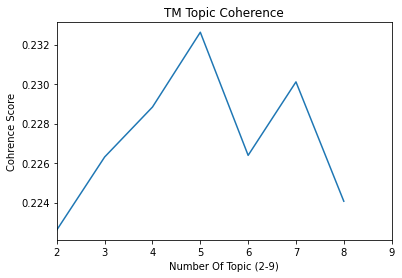

In [25]:
import matplotlib.pyplot as plt  
import numpy

k=[]
for i in range(2,9):
    k.append(i)

x=numpy.array(k)
y=numpy.array(tm_coherence_score)
plt.title('TM Topic Coherence')
plt.plot(x,y)
plt.xlim(2,9)
plt.xlabel('Number Of Topic (2-9)')
plt.ylabel('Cohrence Score')
plt.show()

#### 토픽의 갯수가 증가할수록 계속적으로 정합지수(coherence score)가 증가하는 추이를 보인다. 증가 추이에서 score가 계속 높아지다가 낮아지기 시작할 때, 낮아지기 직전의 가장 높은 값을 적절한 토픽의 갯수로 판단하고, LDA 모델을 생성한다.


In [30]:
tm_model = gensim.models.ldamodel.LdaModel(corpus=tm_corpus, id2word=tm_id2word, num_topics=5)
tm_model.print_topics()
tm_model.print_topics(num_words=30) # 각 토픽별 단어 수 설정

[(0,
  '0.088*"매직" + 0.060*"청소기" + 0.031*"물걸레" + 0.025*"무선" + 0.022*"공기" + 0.019*"식기세척기" + 0.018*"청정기" + 0.015*"사용" + 0.011*"후기" + 0.010*"정수기" + 0.010*"청소" + 0.009*"클린" + 0.009*"스핀" + 0.008*"로봇" + 0.008*"먼지" + 0.008*"건조기" + 0.008*"집" + 0.007*"추천" + 0.007*"구매" + 0.007*"렌탈" + 0.007*"필터" + 0.006*"물" + 0.006*"케어" + 0.005*"인용" + 0.005*"가격" + 0.005*"업" + 0.005*"제품" + 0.004*"설치" + 0.004*"진공청소기" + 0.004*"트리플"'),
 (1,
  '0.092*"매직" + 0.068*"청소기" + 0.029*"청정기" + 0.024*"공기" + 0.023*"식기세척기" + 0.019*"무선" + 0.018*"물걸레" + 0.015*"사용" + 0.011*"로봇" + 0.010*"후기" + 0.009*"클린" + 0.009*"제품" + 0.009*"렌탈" + 0.009*"정수기" + 0.009*"먼지" + 0.009*"스핀" + 0.008*"추천" + 0.008*"청소" + 0.007*"필터" + 0.007*"건조기" + 0.006*"구매" + 0.005*"케어" + 0.005*"물" + 0.005*"인용" + 0.005*"집" + 0.004*"가격" + 0.004*"업" + 0.004*"관리" + 0.004*"설치" + 0.004*"듀얼"'),
 (2,
  '0.106*"매직" + 0.072*"청소기" + 0.029*"청정기" + 0.021*"공기" + 0.018*"물걸레" + 0.017*"무선" + 0.016*"사용" + 0.015*"식기세척기" + 0.011*"후기" + 0.010*"정수기" + 0.010*"로봇" + 0.009*"먼지" + 0.009*"클린" + 0.00

## pyLDAvis를 이용한 LDA 시각화 IDM
LDA를 시각화하기 pyLDAvis 라이브러리를 import 해야 한다. pyLDAvis 라이브러리는 명령어 pip install pyLDAvis를 이용하여 설치해야 한다. 설치가 완료되면 실제 생성한 모델을 가지고 토픽간 거리지도(IDM)으로 시각화한다. 

In [35]:
!pip install pyLDavis

You should consider upgrading via the 'C:\Users\realy\anaconda3\envs\py37\python.exe -m pip install --upgrade pip' command.



  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing wheel metadata (pyproject.toml): started
  Preparing wheel metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyLDavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=b75abb3d9a8e321407b984544f85f2a17a4689fd5f389f54ddb6bcba234f04d4
  Stored in directory: c:\users\realy\appdata\local\pip\cache\wheels\c9\21\f6\17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=0d54becfc44c9c3936be50e06ad657e80026813c2e4b86fd488db28255e7a2fa
  Stored 

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

prepared_data = gensimvis.prepare(tm_model, tm_corpus, tm_id2word)
pyLDAvis.display(prepared_data)

C:\Users\realy\anaconda3\envs\py37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 동적 토픽 모델링(Dynamic Topic Modeling)

동적 토픽 모델링을 적용하기 위해서 텍스트 데이터에서 시간에 따른 분류로 전처리한다. 각 데이터는 특정 시간에 포함된 문서들의 단어들로 분류가 된다.

In [43]:
tm_nouns_date={}
for i in range(len(tm_posts)):
    try:
        if tm_post_date[i] in tm_nouns_date:
            tm_nouns_date[tm_post_date[i]].append(tm_nouns[i])
        else:
            tm_nouns_date[tm_post_date[i]]=[]
            try:
                tm_nouns_date[tm_post_date[i]].append(tm_nouns[i])
            except:
                pass
    except:
        pass

tm_nouns_date = sorted(tm_nouns_date.items())
tm_nouns_date[0]

('20161202',
 [['차트',
   '뉴스',
   '매직',
   '식기세척기',
   '시장',
   '만년',
   '위',
   '빨래',
   '건조기',
   '로봇',
   '청소기',
   '신',
   '물건',
   '가전',
   '신기',
   '매직',
   '절반',
   '이상',
   '점유',
   '차지',
   '위',
   '자리',
   '확인',
   '매직',
   '동양',
   '매직',
   '매직',
   '이름',
   '슈퍼',
   '공기',
   '청정기',
   '동양',
   '매직',
   '매직',
   '이름',
   '슈퍼',
   '공기',
   '청정기',
   '렌탈',
   '사용',
   '저희',
   '침구',
   '청소기',
   '사용',
   '침구',
   '청소',
   '청소기',
   '먼지',
   '매직',
   '무선',
   '청소기',
   '봉기',
   '사용',
   '매직',
   '무선',
   '청소기',
   '지금',
   '유선',
   '청소기',
   '무선',
   '청소기',
   '구입',
   '성비',
   '구매',
   '무선',
   '청소기',
   '구입',
   '기념',
   '정성',
   '포스팅',
   '무선',
   '돈',
   '유선',
   '진공',
   '청소기',
   '매직',
   '아기',
   '뒤',
   '머리카락',
   '여념',
   '청소기',
   '검색',
   '돌입',
   '구입',
   '청소기',
   '소형',
   '청소기',
   '청소기',
   '사이',
   '킹',
   '유사',
   '소음',
   '흡입력',
   '자랑',
   '소형',
   '가전',
   '무선',
   '청소기',
   '매직',
   '청소기',
   '사용',
   '비교',
   '먼지',
   '핸드',
   '링',
   '구매',
   '매직',
   '매직

In [44]:
tm_nouns_dates=[]
tm_date_length=[]
for i in range(len(tm_nouns_date)):
    tm_nouns_dates.append(tm_nouns_date[i][1])
    tm_date_length.append(len(tm_nouns_date[i][1]))

tm_date_length[0:20]

[1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 3, 1, 2, 1, 2, 1, 1]

In [45]:
tm_merged_dates=[]
for posts in tm_nouns_dates:
    for post in posts:
        tm_merged_dates=tm_merged_dates+[post]

tm_merged_dates[0]

['차트',
 '뉴스',
 '매직',
 '식기세척기',
 '시장',
 '만년',
 '위',
 '빨래',
 '건조기',
 '로봇',
 '청소기',
 '신',
 '물건',
 '가전',
 '신기',
 '매직',
 '절반',
 '이상',
 '점유',
 '차지',
 '위',
 '자리',
 '확인',
 '매직',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '동양',
 '매직',
 '매직',
 '이름',
 '슈퍼',
 '공기',
 '청정기',
 '렌탈',
 '사용',
 '저희',
 '침구',
 '청소기',
 '사용',
 '침구',
 '청소',
 '청소기',
 '먼지',
 '매직',
 '무선',
 '청소기',
 '봉기',
 '사용',
 '매직',
 '무선',
 '청소기',
 '지금',
 '유선',
 '청소기',
 '무선',
 '청소기',
 '구입',
 '성비',
 '구매',
 '무선',
 '청소기',
 '구입',
 '기념',
 '정성',
 '포스팅',
 '무선',
 '돈',
 '유선',
 '진공',
 '청소기',
 '매직',
 '아기',
 '뒤',
 '머리카락',
 '여념',
 '청소기',
 '검색',
 '돌입',
 '구입',
 '청소기',
 '소형',
 '청소기',
 '청소기',
 '사이',
 '킹',
 '유사',
 '소음',
 '흡입력',
 '자랑',
 '소형',
 '가전',
 '무선',
 '청소기',
 '매직',
 '청소기',
 '사용',
 '비교',
 '먼지',
 '핸드',
 '링',
 '구매',
 '매직',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '성능',
 '경험',
 '안녕',
 '품격',
 '블로그',
 '주인장',
 '대표',
 '집안',
 '환경',
 '이방',
 '콘센트',
 '매직',
 '무선',
 '청소기',
 '동급',
 '최강',
 '인정',
 '매직',
 '무선',
 '청소기',
 '

In [54]:
import gensim
from gensim import corpora

def docLDA(nouns):
    bigram = gensim.models.Phrases(nouns)
    trigram = gensim.models.Phrases(bigram[nouns])
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    bigram_document = [bigram_mod[doc] for doc in nouns]
    id2word = corpora.Dictionary(bigram_document)

    corpus = [id2word.doc2bow(doc) for doc in bigram_document]
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5)   # 토픽의 수를 설정
    
    return model, corpus, id2word

In [55]:
tm_model, tm_corpus, tm_id2word = docLDA(tm_nouns)
tm_model.print_topics(num_words=45) # 각 토픽별 단어 수 설정

[(0,
  '0.109*"매직" + 0.058*"청소기" + 0.026*"물걸레" + 0.020*"식기세척기" + 0.020*"공기" + 0.019*"청정기" + 0.017*"무선" + 0.012*"사용" + 0.011*"클린" + 0.010*"후기" + 0.010*"스핀" + 0.009*"필터" + 0.009*"청소" + 0.009*"로봇" + 0.009*"먼지" + 0.008*"정수기" + 0.008*"렌탈" + 0.007*"제품" + 0.007*"케어" + 0.006*"가격" + 0.005*"추천" + 0.005*"인용" + 0.005*"설치" + 0.005*"트리플" + 0.005*"집" + 0.004*"구매" + 0.004*"업" + 0.004*"물" + 0.004*"관리" + 0.004*"직수" + 0.004*"가전" + 0.004*"건조기" + 0.004*"듀얼" + 0.003*"가능" + 0.003*"진공청소기" + 0.003*"핏" + 0.003*"사은품" + 0.003*"모델" + 0.003*"제거" + 0.003*"바이러스" + 0.003*"우리" + 0.003*"진공" + 0.003*"업소" + 0.003*"구입" + 0.003*"전"'),
 (1,
  '0.089*"매직" + 0.071*"청소기" + 0.028*"공기" + 0.026*"식기세척기" + 0.025*"물걸레" + 0.019*"청정기" + 0.015*"무선" + 0.011*"사용" + 0.011*"먼지" + 0.010*"정수기" + 0.010*"후기" + 0.009*"청소" + 0.008*"스핀" + 0.008*"추천" + 0.008*"필터" + 0.007*"클린" + 0.007*"로봇" + 0.007*"인용" + 0.007*"렌탈" + 0.007*"케어" + 0.007*"제품" + 0.006*"집" + 0.006*"물" + 0.006*"가격" + 0.005*"설치" + 0.005*"건조기" + 0.005*"업" + 0.004*"듀얼" + 0.004*"제거" + 0.004*

getTopics 함수는 LDA 모델에 포함된 각 토픽들에 대해서 반환한다. 블로그 텍스트에서 getTopics 함수를 통해 토픽들을 살펴본다.

In [48]:
def getTopics(model):
    topics = []
    for topic in model.print_topics():
        i=1
        model_words=[]
        topic_words=str(topic).split('"')
        for words in topic_words:
            if i%2==0:
                model_words.append(words)
            i+=1
        topics.append(model_words)
    return topics

In [49]:
tm_topics = getTopics(tm_model)
tm_topics

[['청소기', '매직', '물걸레', '식기세척기', '공기', '청정기', '사용', '로봇', '후기', '무선'],
 ['매직', '청소기', '물걸레', '식기세척기', '공기', '사용', '청정기', '무선', '스핀', '로봇'],
 ['매직', '청소기', '물걸레', '공기', '청정기', '식기세척기', '무선', '사용', '클린', '렌탈'],
 ['매직', '청소기', '공기', '물걸레', '식기세척기', '청정기', '무선', '후기', '렌탈', '사용'],
 ['매직', '청소기', '물걸레', '청정기', '공기', '무선', '식기세척기', '사용', '후기', '청소'],
 ['매직', '청소기', '식기세척기', '물걸레', '공기', '청정기', '무선', '사용', '정수기', '스핀']]

동적 토픽 모델로 살펴보기 위해 문서마다 가지고 있는 토픽들의 크기를 알아야 한다. 여기서는 날짜별로 합쳐진 문서마다 토픽들의 크기를 계산한다.

In [57]:
tm_topic_size=[]
index=0
for post_len in tm_date_length:
    topic_size=[]
    doc=[]
    for i in range(post_len):
        doc+=tm_merged_dates[index]
        index+=1
    for model in tm_topics:
        count=0
        for noun in doc:
            if noun in model:
                count+=1
        topic_size.append(count)
    tm_topic_size.append(topic_size)

tm_topic_size[0:6]

[[4325, 4304, 4293, 4312, 4336, 4304],
 [4325, 4304, 4293, 4312, 4336, 4304],
 [4325, 4304, 4293, 4312, 4336, 4304],
 [4325, 4304, 4293, 4312, 4336, 4304],
 [4325, 4304, 4293, 4312, 4336, 4304],
 [4325, 4304, 4293, 4312, 4336, 4304]]

Numpy의 배열 형태로 저장하기 위해 변환한다.

In [51]:
import numpy as np
tm_topic_array=np.array(tm_topic_size)
tm_topic_array

array([[ 4325,  4304,  4293,  4312,  4336,  4304],
       [ 4325,  4304,  4293,  4312,  4336,  4304],
       [ 4325,  4304,  4293,  4312,  4336,  4304],
       ...,
       [ 4325,  4304,  4293,  4312,  4336,  4304],
       [ 4325,  4304,  4293,  4312,  4336,  4304],
       [17300, 17216, 17172, 17248, 17344, 17216]])

matplotlib를 이용하여 차트로 시각화하여 시간에 따른 토픽들의 변화를 살펴본다. 차트에서 x축은 시간이 나타내고, y축은 토픽의 크기가 된다.

In [52]:
# print(len(tm_topic_array), len(tm_x))

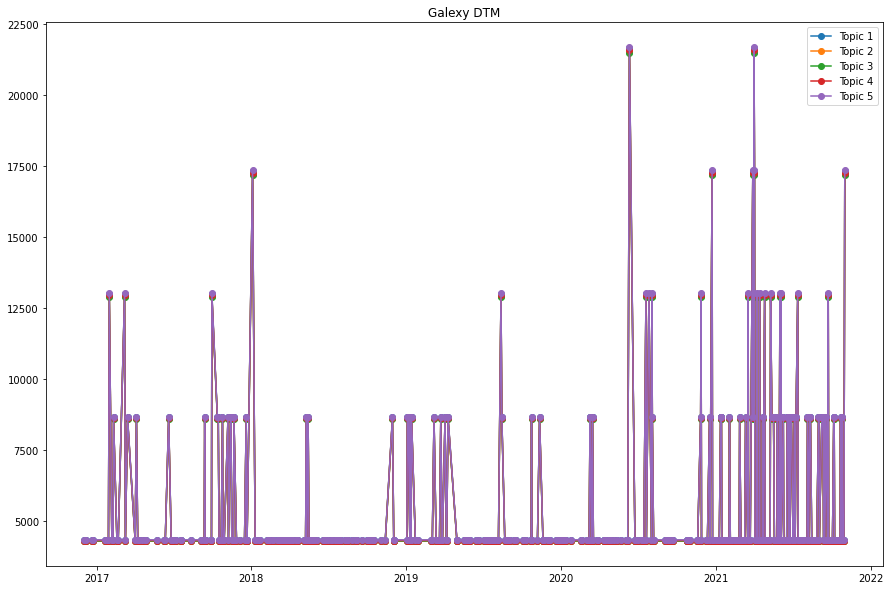

In [53]:
import matplotlib.pyplot as plt
import datetime as dt

tm_x=[]
tm_y=[]

tm_topic_1=tm_topic_array[:,0]
tm_topic_2=tm_topic_array[:,1]
tm_topic_3=tm_topic_array[:,2]
tm_topic_4=tm_topic_array[:,3]
tm_topic_5=tm_topic_array[:,4]
tm_topic_6=tm_topic_array[:,5]

tm_unique_date = sorted(list(set(tm_post_date)))

tm_plt_data=[]
for date in tm_unique_date:
    times= dt.datetime.strptime(str(date),'%Y%m%d')
    tm_x.append(times)

plt.rcParams["figure.figsize"]=(15,10)
plt.title("Galexy DTM")
plt.plot(tm_x, tm_topic_1,'o-', label="Topic 1")
plt.plot(tm_x, tm_topic_2,'o-', label="Topic 2")
plt.plot(tm_x, tm_topic_3,'o-', label="Topic 3")
plt.plot(tm_x, tm_topic_4,'o-', label="Topic 4")
plt.plot(tm_x, tm_topic_5,'o-', label="Topic 5")

plt.legend()
plt.show()

## 각 토픽별 주요단어 추출 및 단어구름으로 시각화
### 각 토픽의 내용을 직관적으로 파악할 수 있도록, 모든 토픽에 공통으로 많이 출현하는 상위 10개 단어를 제외한 중간 수준의 주요 핵심어를 단어구름으로 시각화

In [58]:
from wordcloud import WordCloud

# 아래는 각자에 맞게 단어구름에 속하는 단어 및 상대적 수치 입력하기 

idm_cloud1 = [ ('클린', 9), ('청소', 9), ('스핀', 9), ('로봇', 9), ('렌탈', 8), ('추천', 8), ('제품', 7), ('먼지', 6)
              ,('집', 6), ('건조기', 5), ('바이러스', 5), ('정수기', 5), ('구매', 5), ('듀얼', 5), ('케어', 5)]  
  
idm_cloud2 = [ ('정수기', 11), ('청소', 10), ('제품', 9), ('렌탈', 9), ('먼지', 9), ('필터', 8), ('스핀', 8), ('추천', 7),('구매', 7), ('집', 7)
              , ('건조기', 6), ('듀얼', 5), ('로봇', 5), ('가격', 5), ('케어', 6), ('바이러스', 4)]  

idm_cloud3 = [ ('로봇', 12), ('먼지', 9), ('청소', 9), ('정수기', 8), ('클린', 9), ('렌탈', 8), ('제품', 7), ('케어',7)
              ,('필터', 6), ('건조기', 6), ('설치', 6), ('듀얼', 6), ('가격', 5), ('추천', 5), ('설치', 5), ('집', 5)]  
            
idm_cloud4 = [ ('구매', 10), ('필터', 9), ('정수기', 9), ('먼지', 8), ('추천', 7), ('렌탈', 7), ('로봇', 7), ('집', 6),('케어', 6)
              , ('트리플', 6), ('클린', 6), ('진공청소기', 4), ('관리', 4)]  

idm_cloud5 = [ ('SK매직', 10), ('스핀', 10), ('청소', 9), ('클린', 8), ('제품', 7), ('먼지', 7), ('건조기', 7)
              , ('필터', 6),('렌탈', 6), ('집', 6), ('케어', 5), ('관리', 5), ('추천', 5),('바이러스',4)]              

idm_cloud1 = dict(idm_cloud1)
idm_cloud2 = dict(idm_cloud2)
idm_cloud3 = dict(idm_cloud3)
idm_cloud4 = dict(idm_cloud4)
idm_cloud5 = dict(idm_cloud5)

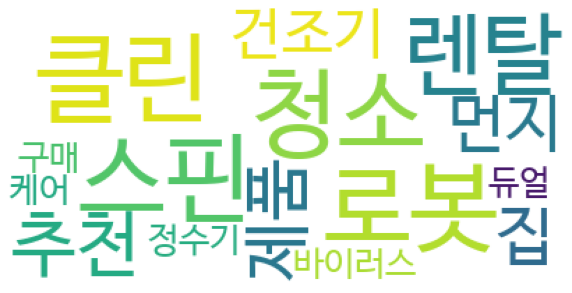

In [59]:
tm_wc = WordCloud(background_color="white", font_path='NanumBarunGothic.ttf')
tm_wc.generate_from_frequencies(idm_cloud1)

import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(tm_wc)

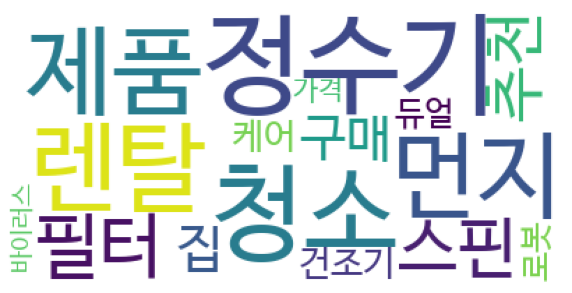

In [60]:
tm_wc = WordCloud(background_color="white", font_path='NanumBarunGothic.ttf')
tm_wc.generate_from_frequencies(idm_cloud2)

import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(tm_wc)

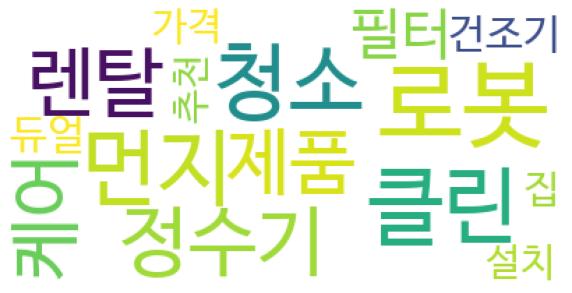

In [61]:
tm_wc = WordCloud(background_color="white", font_path='NanumBarunGothic.ttf')
tm_wc.generate_from_frequencies(idm_cloud3)

import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(tm_wc)

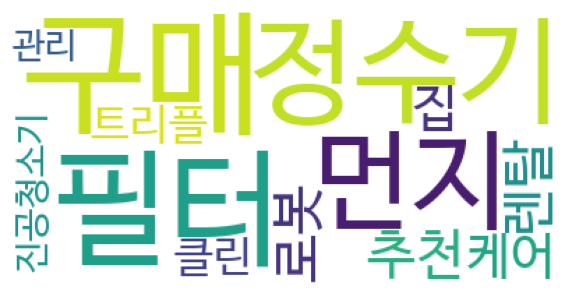

In [62]:
tm_wc = WordCloud(background_color="white", font_path='NanumBarunGothic.ttf')
tm_wc.generate_from_frequencies(idm_cloud4)

import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(tm_wc)

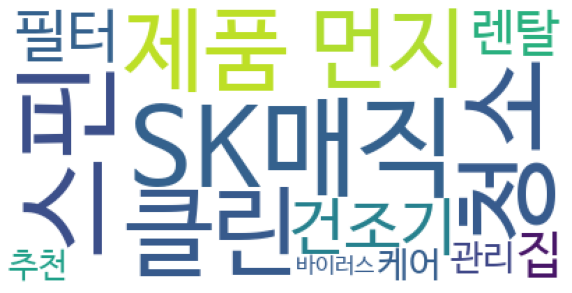

In [63]:
tm_wc = WordCloud(background_color="white", font_path='NanumBarunGothic.ttf')
tm_wc.generate_from_frequencies(idm_cloud5)

import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(tm_wc)